<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 3rd exercise: <font color="#C70039">Do DBScan clustering for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   23.10.2023
* Student: Max Hammer
* Immatriculation ID: 11153562

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/400px-DBSCAN-Illustration.svg.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION</font>:
This notebook allows you for using the DBScan clustering algorithm for anomaly detection.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. take the three data sets from exercize 1 and cluster them
5. read the following <a href="https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan">article</a> for getting help estimating eps and minPts
    * https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan
6. describe your findings and interpret the results
-----------------------------------------------------------------------------------

In [149]:
from sklearn.cluster import DBSCAN
import numpy as np
from numpy.random import randn
np.random.seed(1)
random_data = np.random.randn(50000,2)  * 20 + 20

The output of the below code is 94. This is the total number of noisy points. SKLearn labels the noisy points as (-1). The downside with this method is that the higher the dimension, the less accurate it becomes. You also need to make a few assumptions like estimating the right value for eps which can be challenging.

In [150]:
# hyperparameters
minPts = 2
eps = 3

outlier_detection = DBSCAN(min_samples = minPts, eps = eps)

clusters = outlier_detection.fit_predict(random_data)

list(clusters).count(-1)

94

# Exercise Solution
Datasets that will be used are:
* [Iris](https://www.kaggle.com/uciml/iris)
* [Wine](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)
* [Company profits](https://www.kaggle.com/datasets/tinasoni/normal-distribution-data)

In [151]:
import pandas as pd

# Load data
wine_data = pd.read_csv("./data/wine/winequality-red.csv", sep=",") # normally-distributed 
iris_data = pd.read_csv("./data/iris/Iris.csv", sep=",") # non-normally distributed
profit_data = pd.read_csv("./data/company_profits/CompanyABCProfit.csv", sep=",") # normally-distributed

In [152]:
def find_outliers(data, minPts=2, eps=3):
    outlier_detection = DBSCAN(min_samples = minPts, eps = eps)

    clusters = outlier_detection.fit_predict(data)
    outliers = list(clusters).count(-1)
    print("Number of outliers: ", outliers)

    return clusters

Optimal epsilon value: 102.20


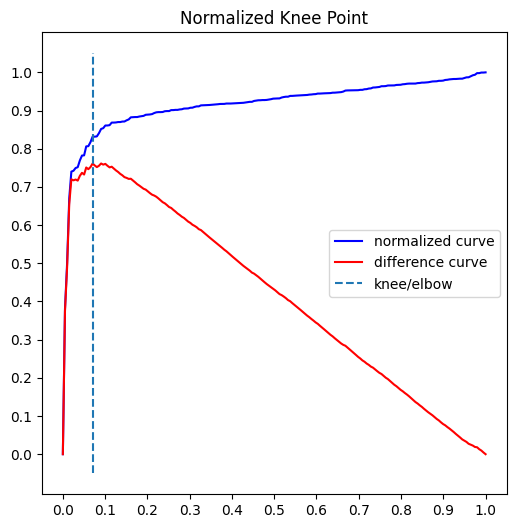

In [153]:
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

# https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan
def calc_knee(data, neighbors=6):
    # X_embedded is your data
    nbrs = NearestNeighbors(n_neighbors=neighbors).fit(data)
    distances, indices = nbrs.kneighbors(data)

    # sort distances descending
    distance_desc = sorted(distances[:,neighbors-1], reverse=True)

    px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc)

    kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                        distance_desc, # y values
                        S=1.0, #parameter suggested from paper
                        curve="convex", #parameter from figure
                        direction="decreasing") #parameter from figure

    kneedle.plot_knee_normalized()
    print(f"Optimal epsilon value: {kneedle.knee_y:.2f}")
    return kneedle.knee_y

epsilon = calc_knee(profit_data, neighbors=6)

Number of outliers:  3
     Year  Profit
105  1926    -244
167  1988    -413
197  2018    -178


<Axes: xlabel='Year', ylabel='Profit'>

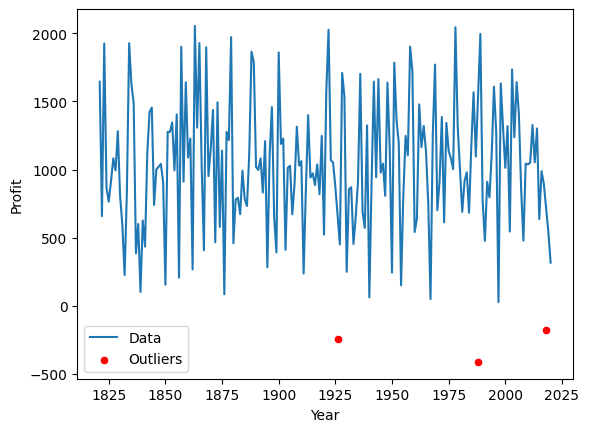

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Company profits
outliers = find_outliers(profit_data, minPts=3, eps=epsilon)

# convert all values that are > -1 to 0
outliers[outliers > -1] = 0

# filter out all values from profit_data that are not outliers
profit_no_outliers_data = profit_data[outliers != -1]
profit_outlier_data = profit_data[outliers == -1]

print(profit_outlier_data.head())


# Scatter plot of data and outliers
sns.lineplot(x="Year", y="Profit", data=profit_no_outliers_data, label="Data")
sns.scatterplot(x="Year", y="Profit", data=profit_outlier_data, label="Outliers", color="red")


### Findings
Only the negative profit values are considered as outliers. The positive values are not considered as outliers.
The min sample points were estimated by me to be 3, meaning that the values of years close to one another should have relatively small distances

Optimal epsilon value: 1.60


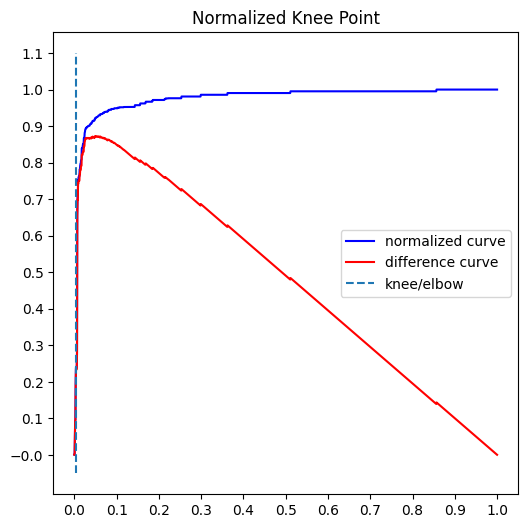

In [155]:
# Wine data
# create data with columns "residual sugar" and "pH"
data = wine_data[["residual sugar", "pH"]]

# Calculate optimal epsilon value for wine data
epsilon = calc_knee(data, neighbors=6)

Number of outliers:  11


<Axes: xlabel='pH', ylabel='residual sugar'>

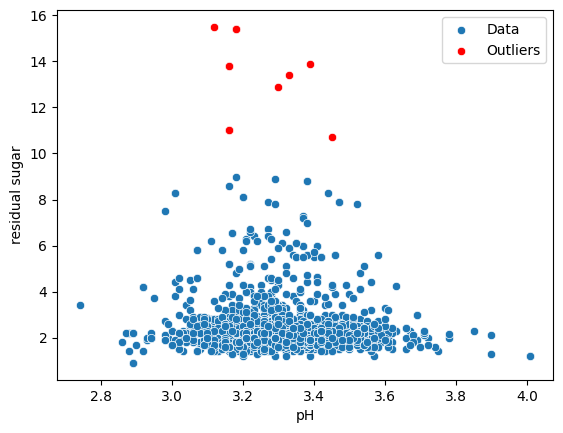

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

outliers = find_outliers(data, minPts=10, eps=epsilon)

# convert all values that are > -1 to 0
outliers[outliers > -1] = 0

# filter out all values from wine that are not outliers
wine_no_outliers_data = data[outliers != -1]
wine_outlier_data = data[outliers == -1]

# Scatter plot of data and outliers
sns.scatterplot(x="pH", y="residual sugar", data=wine_no_outliers_data, label="Data")
sns.scatterplot(x="pH", y="residual sugar", data=wine_outlier_data, label="Outliers", color="red")


### Findings
We can observe a lare cluster of points around the center of the graph. Interestingly, data points with very low or very high pH values were not considered to be outliers by the algorithm. It seems like no matter the pH value, abnormal high values of residual sugar determine whether a point is an outlier or not.

Optimal epsilon value: 3.59


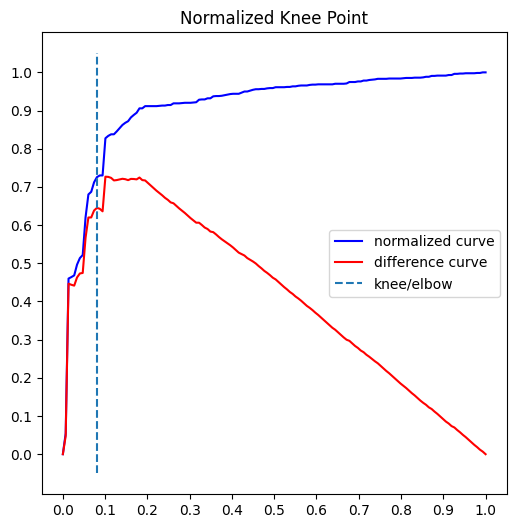

In [157]:
# Iris data
# remove Species column
data = iris_data.drop(columns=["Species"])

# Calculate optimal epsilon value for wine data
epsilon = calc_knee(data, neighbors=6)

Number of outliers:  0


<Axes: xlabel='PetalWidthCm', ylabel='PetalLengthCm'>

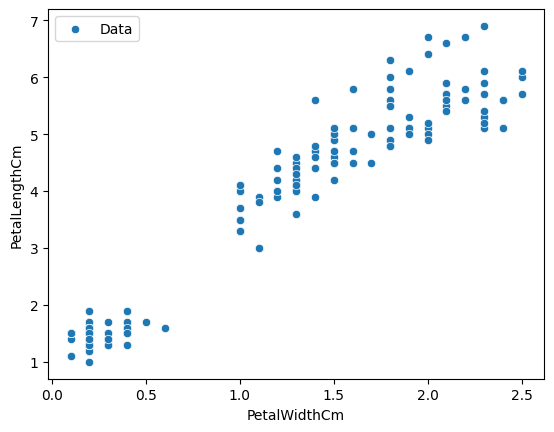

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

outliers = find_outliers(data, minPts=5, eps=epsilon)

# convert all values that are > -1 to 0
outliers[outliers > -1] = 0

# filter out all values from iris that are not outliers
iris_no_outliers_data = data[outliers != -1]
iris_outlier_data = data[outliers == -1]

# Scatter plot of data and outliers
sns.scatterplot(x="PetalWidthCm", y="PetalLengthCm", data=iris_no_outliers_data, label="Data")
sns.scatterplot(x="PetalWidthCm", y="PetalLengthCm", data=iris_outlier_data, label="Outliers", color="red")


### Findings
Interestingly the DBSCAN algorithm did not work on the iris data set. The standard deviation and boxplot approach was able to detect some outliers. I was expecting to see some outliers as a cluster of points of a specific species. But since this is not a cluster algorithm, but rather a outlier detection algorithm, it makes sense that it did not work.